<h1>L1 Regularization</h1>

Lasso Regression Results:
Train R²: 1.000000, Test R²: 1.000000
Train RMSE: 0.194878, Test RMSE: 0.204993
Optimal Alpha (λ): 0.000100
Diagnosis: ✅ Best Fit (good generalization)

Coefficient Estimates (Lasso):
          Feature    Lasso_Coef
0       size_sqft  44513.308424
1    num_bedrooms  14225.326474
2   num_bathrooms   8020.437846
3       age_years -14853.974607
4  location_score  13199.101181


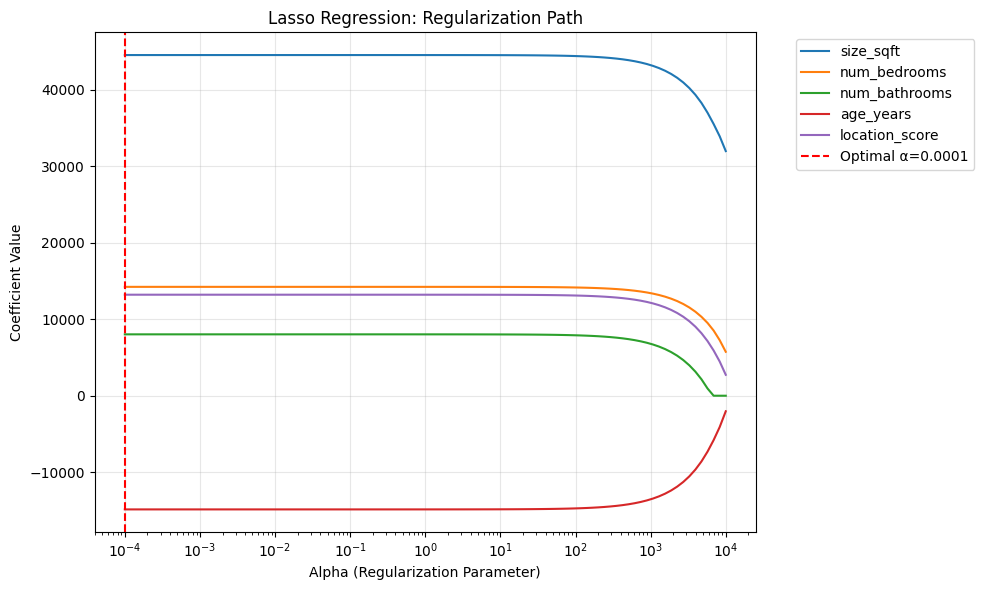

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
# Generate nearly perfect house price dataset
# --------------------------
np.random.seed(42)
n_samples = 500

# Features
size_sqft = np.random.normal(2000, 300, n_samples).clip(800, 4000)
num_bedrooms = np.random.choice([1, 2, 3, 4, 5], n_samples)
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples)
age_years = np.random.randint(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Deterministic price formula (minimal noise)
price = (
    size_sqft * 150 +
    num_bedrooms * 10000 +
    num_bathrooms * 7000 +
    (50 - age_years) * 1000 +
    location_score * 5000
)

# Create DataFrame
house_data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'price': price
})

# --------------------------
# Prepare data
# --------------------------
X = house_data.drop('price', axis=1)
y = house_data['price']
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# Lasso regression with CV
# --------------------------
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 50), cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

lasso_model = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

# --------------------------
# Predictions and Performance
# --------------------------
y_train_pred = lasso_model.predict(X_train_scaled)
y_test_pred = lasso_model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Lasso Regression Results:")
print(f"Train R²: {train_r2:.6f}, Test R²: {test_r2:.6f}")
print(f"Train RMSE: {train_rmse:.6f}, Test RMSE: {test_rmse:.6f}")
print(f"Optimal Alpha (λ): {lasso_cv.alpha_:.6f}")

# Diagnose fit
if train_r2 > 0.95 and test_r2 > 0.95 and abs(train_r2 - test_r2) < 0.02:
    print("Diagnosis: ✅ Best Fit (good generalization)")
elif train_r2 > test_r2 + 0.05:
    print("Diagnosis: ⚠️ Overfitting")
elif train_r2 < 0.5 and test_r2 < 0.5:
    print("Diagnosis: ❌ Underfitting")
else:
    print("Diagnosis: ℹ️ Needs further tuning")

# --------------------------
# Coefficient comparison
# --------------------------
coef_comparison = pd.DataFrame({
    'Feature': feature_names,
    'Lasso_Coef': lasso_model.coef_
})
print("\nCoefficient Estimates (Lasso):")
print(coef_comparison)

# --------------------------
# Plot Lasso regularization path
# --------------------------
alphas = np.logspace(-4, 4, 100)
coefs = []

for alpha in alphas:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000)
    lasso_temp.fit(X_train_scaled, y_train)
    coefs.append(lasso_temp.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(10, 6))
for i, feature in enumerate(feature_names):
    plt.plot(alphas, coefs[:, i], label=feature)

plt.xscale('log')
plt.xlabel('Alpha (Regularization Parameter)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression: Regularization Path')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f'Optimal α={lasso_cv.alpha_:.4f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<h1>Save the Lasso model and scaler</h1>

In [6]:
import joblib

# Save the trained Lasso model
joblib.dump(lasso_model, "model/lasso_model.pkl")

# Save the scaler
joblib.dump(scaler, "model/scaler_lasso.pkl")


['model/scaler_lasso.pkl']

<h1> Both L1,L2 Regularization</h1>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# Generate nearly perfect house price dataset
# --------------------------
np.random.seed(42)
n_samples = 500

# Features
size_sqft = np.random.normal(2000, 300, n_samples).clip(800, 4000)
num_bedrooms = np.random.choice([1, 2, 3, 4, 5], n_samples)
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples)
age_years = np.random.randint(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Deterministic price formula (minimal noise)
price = (
    size_sqft * 150 +
    num_bedrooms * 10000 +
    num_bathrooms * 7000 +
    (50 - age_years) * 1000 +
    location_score * 5000
)

# Create DataFrame
house_data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'price': price
})

# --------------------------
# Prepare data
# --------------------------
X = house_data.drop('price', axis=1)
y = house_data['price']
feature_names = X.columns

# ------------------------------
# Train/Test Split + Scaling
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# OLS Regression
# ------------------------------
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

# ------------------------------
# Ridge Regression
# ------------------------------
ridge_cv = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=5)
ridge_cv.fit(X_train_scaled, y_train)
ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train_scaled, y_train)

# ------------------------------
# Lasso Regression
# ------------------------------
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
lasso_model = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
n_selected_features = np.sum(lasso_model.coef_ != 0)

# ------------------------------
# Function to check Overfit/Underfit/Best Fit
# ------------------------------
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print(f"\n{name} Results:")
    print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    
    # Diagnose
    if train_r2 > 0.95 and test_r2 > 0.95 and abs(train_r2 - test_r2) < 0.02:
        status = "✅ Best Fit (good generalization)"
    elif train_r2 > test_r2 + 0.05:
        status = "⚠️ Overfitting"
    elif train_r2 < 0.5 and test_r2 < 0.5:
        status = "❌ Underfitting"
    else:
        status = "ℹ️ Needs further tuning"
    
    print("Diagnosis:", status)
    return train_r2, test_r2, train_rmse, test_rmse

# ------------------------------
# Evaluate Models
# ------------------------------
results = {}
results["OLS"] = evaluate_model("OLS", ols_model, X_train_scaled, y_train, X_test_scaled, y_test)
results["Ridge"] = evaluate_model("Ridge", ridge_model, X_train_scaled, y_train, X_test_scaled, y_test)
results["Lasso"] = evaluate_model("Lasso", lasso_model, X_train_scaled, y_train, X_test_scaled, y_test)

# ------------------------------
# Performance Comparison DataFrame
# ------------------------------
comparison_df = pd.DataFrame({
    "Method": list(results.keys()),
    "Train R²": [v[0] for v in results.values()],
    "Test R²": [v[1] for v in results.values()],
    "Train RMSE": [v[2] for v in results.values()],
    "Test RMSE": [v[3] for v in results.values()],
    "Features Used": [X.shape[1], X.shape[1], n_selected_features]
})

print("\nPerformance Comparison:")
print(comparison_df)

# ------------------------------
# Key Results
# ------------------------------
print(f"\nOptimal Ridge Alpha: {ridge_cv.alpha_:.4f}")
print(f"Optimal Lasso Alpha: {lasso_cv.alpha_:.4f}")



OLS Results:
Train R²: 1.0000, Test R²: 1.0000
Train RMSE: 0.0000, Test RMSE: 0.0000
Diagnosis: ✅ Best Fit (good generalization)

Ridge Results:
Train R²: 1.0000, Test R²: 1.0000
Train RMSE: 0.0136, Test RMSE: 0.0149
Diagnosis: ✅ Best Fit (good generalization)

Lasso Results:
Train R²: 1.0000, Test R²: 1.0000
Train RMSE: 0.0525, Test RMSE: 0.0548
Diagnosis: ✅ Best Fit (good generalization)

Performance Comparison:
  Method  Train R²  Test R²    Train RMSE     Test RMSE  Features Used
0    OLS       1.0      1.0  5.015663e-11  5.107702e-11              5
1  Ridge       1.0      1.0  1.363886e-02  1.485586e-02              5
2  Lasso       1.0      1.0  5.254033e-02  5.479288e-02              5

Optimal Ridge Alpha: 0.0001
Optimal Lasso Alpha: 0.0001


<h1>Save models and scaler</h1>

In [5]:
import numpy as np
import joblib

# Save model parameters instead of whole object
np.savez('models_l1_l2_ols/ols_model_params.npz', coef=ols_model.coef_, intercept=ols_model.intercept_)
np.savez('models_l1_l2_ols/ridge_model_params.npz', coef=ridge_model.coef_, intercept=ridge_model.intercept_)
np.savez('models_l1_l2_ols/lasso_model_params.npz', coef=lasso_model.coef_, intercept=lasso_model.intercept_)

joblib.dump(scaler, 'models_l1_l2_ols/scaler.pkl')  # Keep scaler saved


['models_l1_l2_ols/scaler.pkl']